In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter
from community import community_louvain
from matplotlib.cm import ScalarMappable
from sklearn.metrics import adjusted_rand_score
import random
import os
import json
from matplotlib.cm import ScalarMappable


### Prepare the Network and Data

In [2]:
data_folder_path = '../data/'

all_data = {}

for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        json_file_path = os.path.join(data_folder_path, filename)
        
        with open(json_file_path, 'r') as file:
            all_data[os.path.splitext(filename)[0]] = json.load(file)

In [3]:
### Add sentiment score as a character attribute

characters_infobox = all_data['characters_infobox']
sentiment_scores_characters = all_data['sentiment_scores_charachters']

for character, info in characters_infobox.items():
    if character in sentiment_scores_characters:
        info['Sentiment Score'] = sentiment_scores_characters[character]


In [4]:
def create_character_interaction_graph(data, season=None, characters_info=None):
    graph_dict = {}  # Initialize an empty dictionary to store graphs
    count = 1  # Initializing a count

    # Loop over every season
    if season is None:
        for season_name, episodes_data in data.items():
            for i in range(len(episodes_data)):
                G = nx.Graph()  # Create a new directed graph for each episode
                characters = episodes_data[i]["Characters"]  # Characters from each episode as a list

                # Add nodes from the previous graph (if it exists). Control statement for the first graph
                if count > 1:
                    G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)

                    # Add edges and update weights from the previous graph
                    for edge in graph_dict[f'G{count-1}'].edges(data=True):
                        char1, char2, data = edge
                        weight = data.get('weight', 0)
                        G.add_edge(char1, char2, weight=weight)

                # Add new characters as nodes
                if characters is not None:  # Control statement if the list of characters is empty/None type
                    G.add_nodes_from(characters)  # Adding the characters

                    # Add weighted edges for characters appearing in the same episode
                    for char1 in characters:
                        for char2 in characters:
                            if char1 != char2:
                                if G.has_edge(char1, char2):
                                    G[char1][char2]['weight'] += 1
                                else:
                                    G.add_edge(char1, char2, weight=1)

                graph_dict[f'G{count}'] = G  # Appending the evolving graph to the dictionary
                count += 1  # Updating the count

    else:
        # Initialize graph and graph dict to append the graphs
        season_data = data[season]  
        graph_dict = {}  # Initialize an empty dictionary to store graphs
        count = 1  # Initializing a count

        # Loop over every episode
        for i in range(len(season_data)):
            G = nx.Graph()  # Create a new directed graph for each episode
            characters = season_data[i]["Characters"]  # Characters from each episode as a list

            # Add nodes from the previous graph (if it exists). Control statement for the first graph
            if count > 1:
                G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)
                
                # Add edges and update weights from the previous graph
                for edge in graph_dict[f'G{count-1}'].edges(data=True):
                    char1, char2, data = edge
                    weight = data.get('weight', 0)
                    G.add_edge(char1, char2, weight=weight)

            # Add new characters as nodes
            if characters is not None:  # Control statement if the list of characters is empty/None type
                G.add_nodes_from(characters)  # Adding the characters

                # Add weighted edges for characters appearing in the same episode
                for char1 in characters:
                    for char2 in characters:
                        if char1 != char2:
                            if G.has_edge(char1, char2):
                                G[char1][char2]['weight'] += 1
                            else:
                                G.add_edge(char1, char2, weight=1)

            graph_dict[f'G{count}'] = G  # Appending the evolving graph to the dictionary
            count += 1  # Updating the count

    # Add node attributes to all graphs
    if characters_info:
        for key, graph in graph_dict.items():
            add_node_attributes(graph, characters_info)

    return graph_dict

# Adding the note attributes from the characters' infobox.
def add_node_attributes(graph, attributes_dict):
    for node, attributes in attributes_dict.items():
        # Normalize the node name
        normalized_node = next((n for n in graph.nodes if node.lower() == n.lower()), None)
        
        # Check if the normalized node exists in the graph
        if normalized_node:
            graph.nodes[normalized_node].update(attributes)

In [5]:
# The dictionary of the 1013 graphs of all the episodes with the characters as nodes. Attributes are added from their infobox on the fandom page.
graph_dict_all_seasons = create_character_interaction_graph(all_data["episodes_seasons_characters"], characters_info=all_data['characters_infobox'])

In [6]:
graph_G1013 = graph_dict_all_seasons['G1013']

### Graph Partitioning 

In [78]:
def compute_partition_and_modularity(graph, node_community_mapping=None):
    
    partition = community_louvain.best_partition(graph, partition=node_community_mapping)
    modularity = community_louvain.modularity(partition, graph)
    nx.set_node_attributes(graph_G1013, partition, 'community')

    return partition, modularity

def print_communities(partition):

    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = [node]
        else:
            communities[community].append(node)

    for community, nodes in sorted(communities.items()):
        print(f"Community {community}: {nodes}")

In [90]:
def visualize_network(graph, partition, layout='spring', title=''):
    
    if layout == 'spring':
       pos = nx.spring_layout(graph, seed=42) 
    elif layout == 'kamada-kawai':
        pos = nx.kamada_kawai_layout(graph)
    
    plt.figure(figsize=(12, 8))

    # Draw network nodes and edges
    nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
    edges = nx.draw_networkx_edges(graph, pos, alpha=0.5)

    # Add colorbar in a separate subplot
    cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
    sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))
    sm.set_array([])

    # Set ticks for discrete values (assuming communities are integer values)
    ticks = sorted(set(partition.values()))
    plt.colorbar(sm, label='Community', cax=cax, ticks=ticks)

    plt.title(title)
    plt.show()

#### Partitioning Based On Villages

In [91]:
def assign_affiliation_labels(graph, target_villages):
    """
    Assigns community labels to nodes in a graph based on the 'Affiliation' attribute.

    Parameters:
    - graph: NetworkX graph
    - target_villages: List of target villages to check for in the 'Affiliation' attribute

    Returns:
    - node_community_mapping: Dictionary mapping nodes to their assigned community labels
    """
    node_community_mapping = {}

    for node in graph.nodes:
        affiliation_list = graph.nodes[node].get('Affiliation', [])

        matching_villages = [village for village in target_villages if village in affiliation_list]

        if matching_villages:
            community_label = matching_villages[0]
        elif affiliation_list:
            community_label = random.choice(affiliation_list)
        else:
            community_label = 'None'

        node_community_mapping[node] = community_label

    return node_community_mapping

Modularity: 0.29004160726976763
Community 0: ['Sasame', 'Kamikiri', 'Jigumo', 'Kagerō', 'Hanzaki', 'Kotohime', 'Arashi', 'Raiga Kurosuki', 'Ranmaru', 'Karashi', 'Sanshō', 'Hachidai', 'Sangorō', 'Rokusuke', 'Sukeza', 'Sazanami', 'Gosunkugi', 'Gatsu', 'Michizō Manaka', 'Chishima', 'Hōki (Watari)', 'Kōmei', 'Sagi', 'Nagare', 'Hokushin', 'wikipedia:Kaishakunin', 'Toki', 'Natsuhi', 'Sumaru', 'Akahoshi', 'Hokuto', 'Mizura', 'Yotaka', 'Shisō', 'Third Hoshikage', 'Hotarubi', 'Tōbei Kagetsu', 'Kiyoyasu Kagetsu', 'Tsukiko Kagetsu', 'Fūta Kagetsu', 'Mai Kagetsu', 'Haruna', 'Yurinojō', 'Kikunojō', 'Momiji', 'Renga', 'Jiga', 'Ruiga', 'Fudō', 'Fuen', 'Kazuma', 'Sora', 'Chiriku', 'Fūka', 'Kitane', 'Nauma', 'Seito', 'Tōu', 'Banna', 'Iggy', 'Hagoromo Ōtsutsuki', 'Hamura Ōtsutsuki', 'Gamamaru', 'Haori', 'Futami', 'Mitsuo', 'Asura', 'Indra', 'Taizō', 'Gasuka', 'Edashi', 'Kanna']
Community 1: ['Tazuna', 'Zabuza Momochi', 'Gatō', 'Meizu', 'Kaji', 'Haku', 'Tsunami', 'Inari', 'Waraji', 'Zōri', 'Kaiza', 'Giic

C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\320978452.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


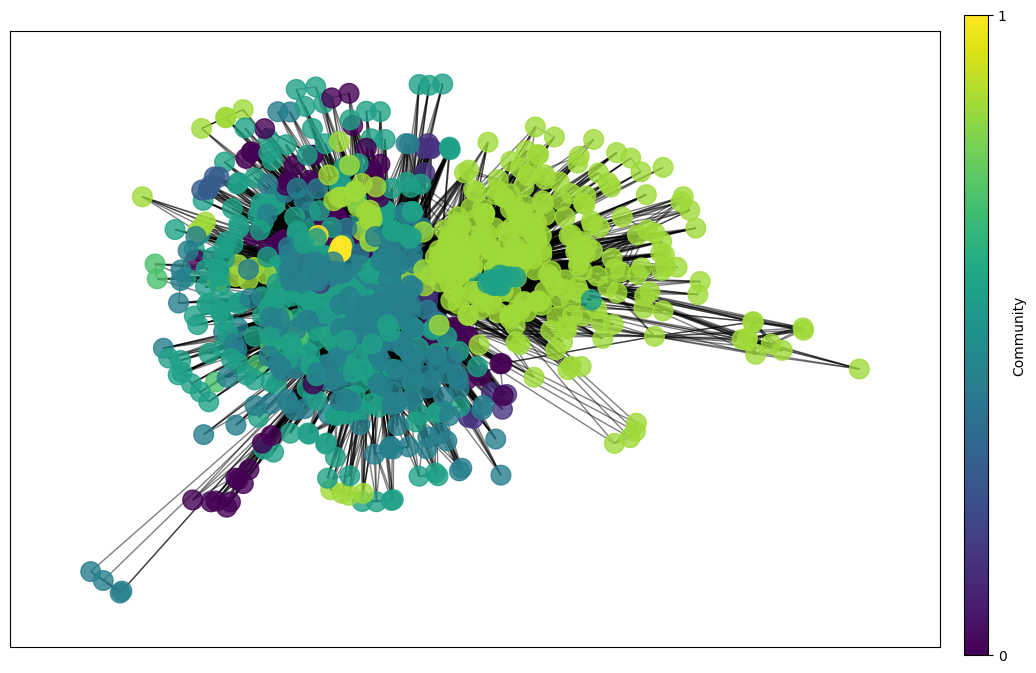

In [92]:
target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(graph_G1013, target_villages)

partition, modularity = compute_partition_and_modularity(graph_G1013, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(graph_G1013, partition)


#### Partitioning Based on Clans

In [52]:
def assign_clan_labels(graph):
    """
    Assigns community labels to nodes in a graph based on the 'Clan' attribute.

    Parameters:
    - graph: NetworkX graph

    Returns:
    - node_community_mapping: Dictionary mapping nodes to their assigned community labels
    """
    node_community_mapping = {}

    for node in graph.nodes:
        clan_list = graph.nodes[node].get('Clan', [])
        community_label = random.choice(clan_list) if clan_list else 'None'
        node_community_mapping[node] = community_label

    return node_community_mapping


Modularity: 0.30340531414035016
Community 0: ['Hagoromo Ōtsutsuki', 'Hamura Ōtsutsuki', 'Gamamaru', 'Haori', 'Futami', 'Mitsuo', 'Asura', 'Indra', 'Taizō', 'Gasuka', 'Edashi', 'Kanna']
Community 1: ['Utakata', 'Hotaru', 'Tonbee', 'Akaboshi', 'Chūshin', 'Nangō', 'Benten', 'Tsuchigumo chief', 'Shiranami', 'Harusame', 'Tsurugi', 'En no Gyōja']
Community 2: ['Sasuke Uchiha', 'Hiruzen Sarutobi', 'Genzō', 'Kakashi Hatake', 'Tazuna', 'Zabuza Momochi', 'Gatō', 'Meizu', 'Kaji', 'Haku', 'Tsunami', 'Inari', 'Waraji', 'Zōri', 'Kaiza', 'Giichi', 'Akane', 'Ageha', "Haku's mother", 'Agari', 'Gaara', 'Temari', 'Kankurō', 'Ningame', 'Kabuto Yakushi', 'Genin', 'Oboro', 'Shiore', 'Itachi Uchiha', 'Orochimaru', 'Mubi', 'Kagari', 'Suzume', 'Yūgao Uzuki', 'Shikaku Nara', 'Chōza Akimichi', 'Inoichi Yamanaka', 'Pakkun', 'First Hokage', 'Second Hokage', 'Zō', 'Enma', 'Shinobu Mibu', 'Yashamaru', 'Kashike', 'Shukaku of the Sand', 'Sajin', 'Kisame Hoshigaki', 'Fugaku Uchiha', 'Mikoto Uchiha', 'Teyaki Uchiha', 'U

C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\4276793230.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\4276793230.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


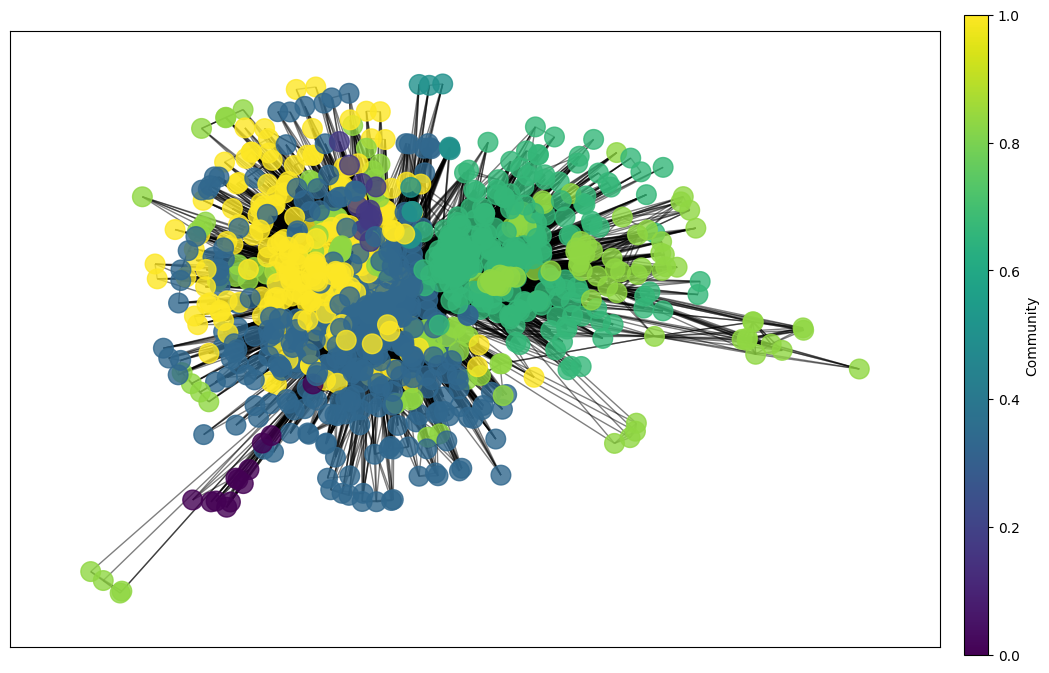

In [81]:
node_community_mapping = assign_clan_labels(graph_G1013)
partition, modularity = compute_partition_and_modularity(graph_G1013, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(graph_G1013, partition)



#### Partitioning based on Louvain Community Detection Algorithm

In [8]:
# Handle missing attributes by setting 'None'
for node in graph_G1013.nodes:
    for attribute in graph_G1013.nodes[node]:
        if attribute not in graph_G1013.nodes[node]:
            graph_G1013.nodes[node][attribute] = 'None'

Modularity: 0.30150037382269457
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Iruka', 'Ino Yamanaka', 'Hinata Hyūga', 'Mizuki', 'Bekkō', 'Iwana', 'Yajirobee', 'Ibara', 'Tsubaki (parent)', 'Iruka Umino', 'Konohamaru', 'Ebisu', 'Genzō', 'Sexy Technique', 'Kakashi Hatake', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Kurenai Yūhi', 'Tobio', 'Mebuki Haruno', 'Madam Shijimi', 'Moegi', 'Udon', 'Kotetsu Hagane', 'Izumo Kamizuki', 'Kabuto Yakushi', 'Ibiki Morino', 'Shino Aburame', 'Tonbo Tobitake', 'Shiore', 'Itachi Uchiha', 'Mozuku', 'Orochimaru', 'Hiashi Hyūga', 'Jiraiya', 'Teuchi', 'Ayame', 'Yūgao Uzuki', 'Homura Mitokado', 'Koharu Utatane', 'Gamabunta', 'Nine-Tailed Fox', 'Kōji', 'Matsuri (Konoha)', 'Futaba', 'Genma Shiranui', 'Hizashi Hyūga', 'Hyūga Elder', 'Kidōmaru', 'Sakon', 'Tayuya', 'Jirōbō', 'Pakkun', 'First Hokage', 'Second Hokage', 'Zō', 'Enma', 'Shinobu Mibu', 'Gamakichi', 'Shukaku of the Sand', 'Shibi Aburame', 'Tsume Inuzuka', 'K

C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\4276793230.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\4276793230.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


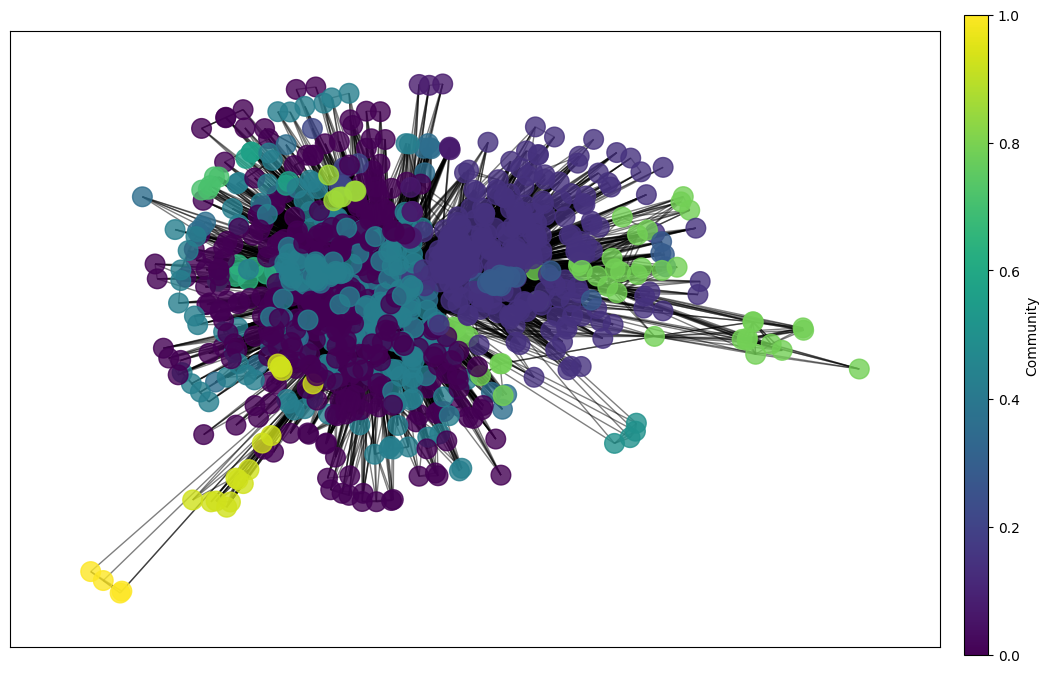

In [82]:
partition, modularity = compute_partition_and_modularity(graph_G1013)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(graph_G1013, partition)


### Build the Complete Graph with min co-occurence constraint

In [47]:
def filter_edges_below_threshold(cumulative_graph, final_graph, threshold):
    # Create a copy of the cumulative graph to avoid modifying the original graph
    filtered_graph = cumulative_graph.copy()

    # Iterate through edges and remove those below the threshold in the final graph (G1013)
    edges_to_remove = [(u, v) for u, v, w in cumulative_graph.edges(data='weight') if final_graph[u][v]['weight'] < threshold]
    filtered_graph.remove_edges_from(edges_to_remove)

    # Identify isolated nodes and remove them
    isolated_nodes = [node for node in filtered_graph.nodes() if filtered_graph.degree(node) == 0]
    filtered_graph.remove_nodes_from(isolated_nodes)

    return filtered_graph

In [58]:
G1013_filtered = filter_edges_below_threshold(graph_dict_all_seasons['G1013'], graph_dict_all_seasons['G1013'], 50)

#### Partitioning based on Villages

Modularity: 0.2846539884435216
Community 0: ['Nagato', 'Konan', 'Yahiko']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Shino Aburame']
Community 2: ['Konohamaru Sarutobi', 'Chōjūrō', 'Boruto Uzumaki', 'Sarada Uchiha', 'Shikadai Nara', 'Chōchō Akimichi', 'Hinata Uzumaki', 'Himawari Uzumaki', 'Denki Kaminarimon', 'Wasabi Izuno', 'Namida Suzumeno', 'Inojin Yamanaka', 'Sumire Kakei', 'Iwabee Yuino', 'Metal Lee', 'Mitsuki', 'Sai Yamanaka', 'Sakura Uchiha', 'Katasuke Tōno', 'Kawaki']
Community 3: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Iruka', 'Iruka Umino', 'Konohamaru', 'Kakashi Hatake', 'Kurenai Yūhi', 'Moegi', 'Udon', 'Kotetsu Hagane', 'Izumo Kamizuki', 'Kabuto Yakushi', 'Anko Mitarashi', 'Itachi Uchiha', 'Orochimaru', 'Baki', 'Jiraiya', 'Teuchi', 'Shikaku Nara', 'Inoichi Yamanaka', 'Pakkun', 'Gamakichi', 

C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\4276793230.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\4276793230.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


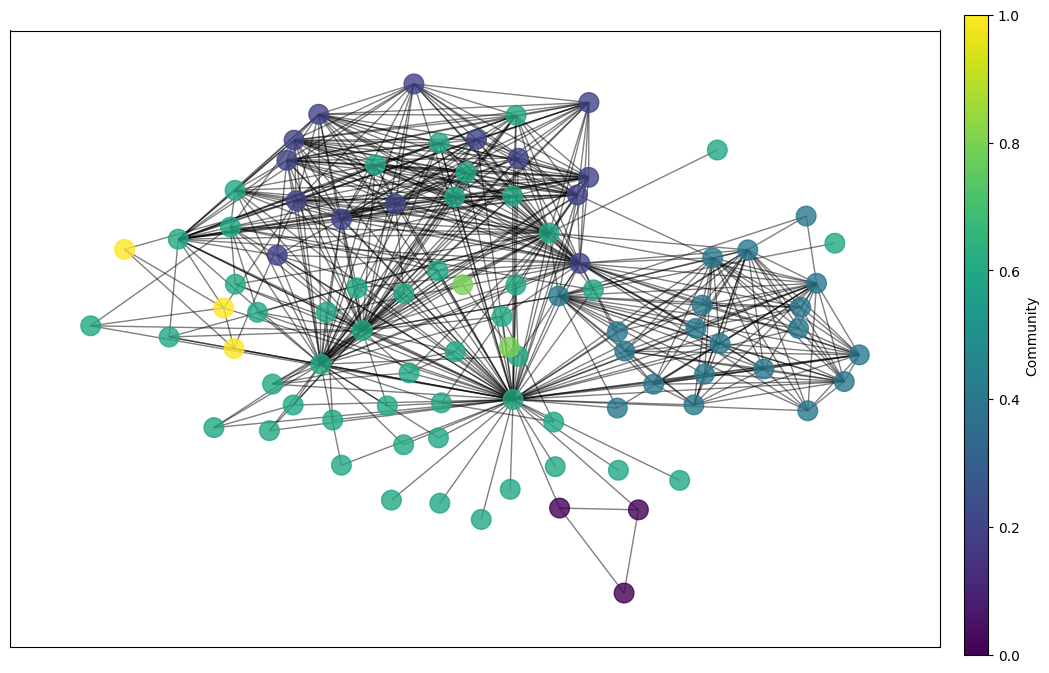

In [88]:
target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(G1013_filtered, target_villages)

partition, modularity = compute_partition_and_modularity(G1013_filtered, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G1013_filtered, partition, layout='kamada-kawai')


#### Partitioning based on Clans

Modularity: 0.28600434984467826
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Iruka', 'Iruka Umino', 'Konohamaru', 'Kakashi Hatake', 'Kurenai Yūhi', 'Moegi', 'Udon', 'Kabuto Yakushi', 'Anko Mitarashi', 'Itachi Uchiha', 'Orochimaru', 'Baki', 'Jiraiya', 'Teuchi', 'Shikaku Nara', 'Inoichi Yamanaka', 'Pakkun', 'Gamakichi', 'Kisame Hoshigaki', 'Fugaku Uchiha', 'Katsuyu', 'Deidara', 'Sasori', 'Chiyo', 'Zetsu', 'Sai', 'Yamato', 'Suigetsu', 'Karin', 'Jūgo', 'Obito Uchiha', 'Minato Namikaze', 'Pain', 'Madara Uchiha', 'Killer B', 'Kurotsuchi', 'Darui', 'Kurama', 'Hashirama Senju']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Shino Aburame', 'Tsunade', 'Shizune']
Community 2: ['Hidan', 'Kakuzu', 'Nagato', 'Konan', 'Yahiko']
Community 3: ['Kotetsu Hagane', 'Izumo Kamizuki', 'A (Fourth Raikage)', 'Mei Terumī',

C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\4276793230.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\4276793230.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


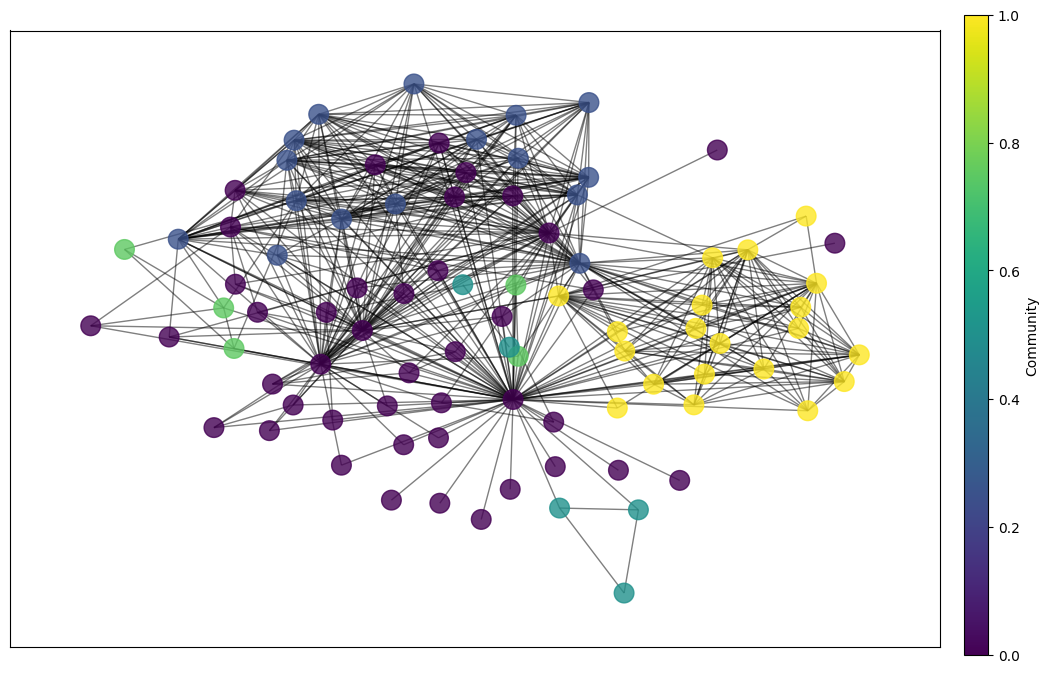

In [87]:
node_community_mapping = assign_clan_labels(G1013_filtered)
partition, modularity = compute_partition_and_modularity(G1013_filtered, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G1013_filtered, partition, layout='kamada-kawai')



#### Partitioning based on Community Detection

Modularity: 0.28488418155861855
Community 0: ['Nagato', 'Konan', 'Yahiko']
Community 1: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Hiruzen Sarutobi', 'Iruka', 'Iruka Umino', 'Konohamaru', 'Kakashi Hatake', 'Moegi', 'Udon', 'Anko Mitarashi', 'Itachi Uchiha', 'Baki', 'Teuchi', 'Shikaku Nara', 'Inoichi Yamanaka', 'Pakkun', 'Gamakichi', 'Kisame Hoshigaki', 'Fugaku Uchiha', 'Katsuyu', 'Deidara', 'Sasori', 'Chiyo', 'Zetsu', 'Suigetsu', 'Karin', 'Jūgo', 'Obito Uchiha', 'Minato Namikaze', 'Pain', 'Madara Uchiha', 'Killer B', 'A (Fourth Raikage)', 'Mei Terumī', 'Ōnoki', 'Kurotsuchi', 'Darui', 'Kurama', 'Hashirama Senju']
Community 2: ['Sakura Haruno', 'Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Kurenai Yūhi', 'Gaara', 'Temari', 'Kankurō', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Kabuto Yakushi', 'Shino Aburame', 'Orochimaru', 'Jiraiya', 'Tsunade', 'Shizune', 'Sai', 'Yamato']
Community 3: ['Konohamaru Sarutobi', 'Chōjūrō', 'Boruto Uzu

C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\4276793230.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_6268\4276793230.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


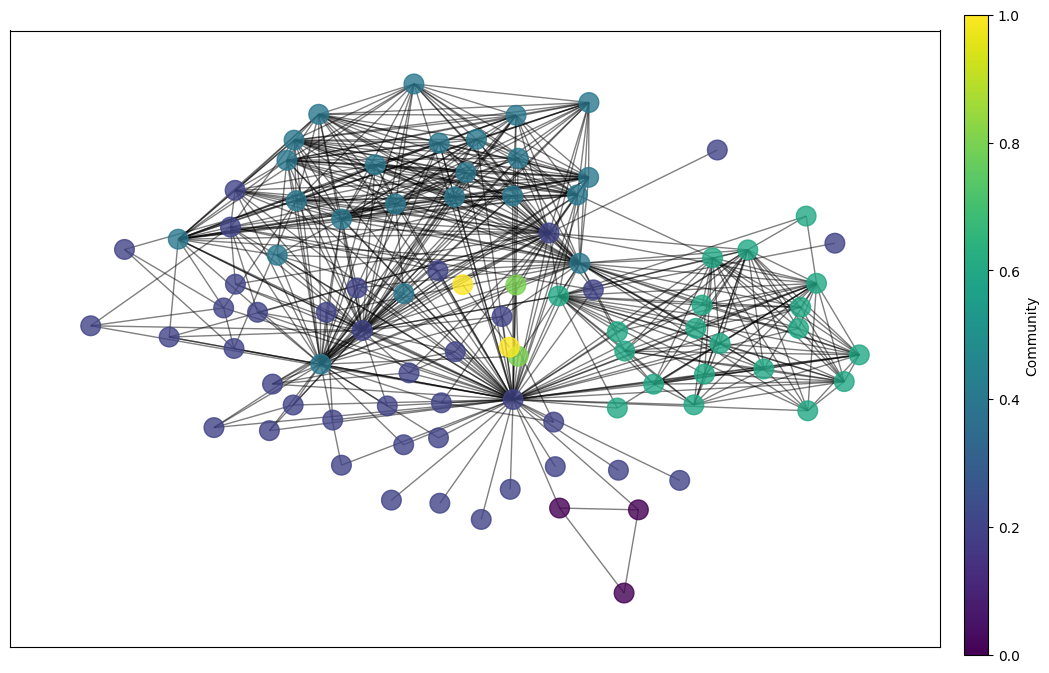

In [86]:
partition, modularity = compute_partition_and_modularity(G1013_filtered)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G1013_filtered, partition, layout='kamada-kawai')
